This notebook will be used to compare the tidal ellipses of the hourly data and the 15 minute data at the VENUS nodes. This notebook will be very similar to Exploring Tidal Ellipses at VENUS nodes.

In [64]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [65]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

#Loading the Hourly Data

The hourly data has a larger archive than the 15 minutes data. The longer time series can help to better calculate tidal ellipses. We will mostly use the same time frame as what we have for the 15 minute data. However we can also compare a months of hourly data sets to a single month of quarter hourly data.

In [66]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
to=datetime.datetime(2015,1,9)
tf=datetime.datetime(2015,5,28)
filesu=analyze.get_filenames(to,tf, '1h', 'grid_U', path)
filesv=analyze.get_filenames(to,tf,'1h', 'grid_V', path)

In [67]:
u_u_c, time = analyze.combine_files(filesu, 'vozocrtx','None',[423,425], [265,267])
v_v_c, timec = analyze.combine_files(filesv, 'vomecrty','None',[423,425], [265,267])
time_c = tidetools.convert_to_seconds(timec)
dep_t_c = nc.Dataset(filesv[-1]).variables['depthv']

u_u_e, time = analyze.combine_files(filesu, 'vozocrtx','None',[415,417], [282,284])
v_v_e, timee = analyze.combine_files(filesv, 'vomecrty','None',[415,417], [282,284])
time_e = tidetools.convert_to_seconds(timee)
dep_t_e = nc.Dataset(filesv[-1]).variables['depthv']

In [68]:
u_u_0 = np.ma.masked_values(u_u_e, 0.0)
v_v_0 = np.ma.masked_values(v_v_e, 0.0)
u_u_0c = np.ma.masked_values(u_u_c, 0.0)
v_v_0c = np.ma.masked_values(v_v_c, 0.0)

u_c, v_c=research_VENUS.unstag_rot_gridded(u_u_0c, v_v_0c, 'Central')
u_e, v_e=research_VENUS.unstag_rot_gridded(u_u_0, v_v_0, 'East')

#Loading 15 minutes data

In [69]:
files = glob.glob(os.path.join(path,'*','*_1h_*_grid_T*'))
    
files = []
files_East = glob.glob(os.path.join(path,'*','VENUS_east_gridded.nc'))
for f in files_East:
    directory=os.path.dirname(f)
    files.append(glob.glob(os.path.join(directory,'*_1h_*_grid_T*'))[0])
files.sort(key=os.path.basename)

files_East = [];
files_Central=[];
for f in files:
    directory=os.path.dirname(f)
    files_East.append(os.path.join(directory,'VENUS_east_gridded.nc'))
    files_Central.append(os.path.join(directory,'VENUS_central_gridded.nc'))

In [70]:
u_u_c_15, timer = analyze.combine_files(files_Central, 'vozocrtx','None',[0,1], [0,1])
v_v_c_15, time = analyze.combine_files(files_Central, 'vomecrty','None', [0,1], [0,1])
time_c_15 = tidetools.convert_to_seconds(timer)
dep_t_c_15 = nc.Dataset(files_Central[-1]).variables['depthv']

u_u_e_15, time = analyze.combine_files(files_East,'vozocrtx', 'None', [0,1], [0,1])
v_v_e_15, time = analyze.combine_files(files_East,'vomecrty', 'None',[0,1], [0,1])
time_e_15 = tidetools.convert_to_seconds(timer)
dep_t_e_15 = nc.Dataset(files_Central[-1]).variables['depthv']

In [71]:
u_u_015 = np.ma.masked_values(u_u_e_15, 0.0)
v_v_015 = np.ma.masked_values(v_v_e_15, 0.0)
u_u_0c15 = np.ma.masked_values(u_u_c_15, 0.0)
v_v_0c15 = np.ma.masked_values(v_v_c_15, 0.0)

u_c_15, v_c_15=research_VENUS.unstag_rot_gridded(u_u_0c15, v_v_0c15, 'Central')
u_e_15, v_e_15=research_VENUS.unstag_rot_gridded(u_u_015, v_v_015, 'East')

#Ellipse Parameter Caculation
Each data source provides information at 40 depths for both Central and East Stations. We will create an array of the ellipse paramaters to simplify calculations and minimize the amount of variables.

In [72]:
times=[time_c,time_e,time_c_15, time_e_15]
us=[u_c, u_e, u_c_15, u_e_15]
vs=[v_c, v_e, v_c_15, v_e_15]
i=np.arange(0,4)

thesize=(40,4)
vM2amp = np.zeros(thesize); vM2pha = np.zeros(thesize)
vK1amp = np.zeros(thesize); vK1pha = np.zeros(thesize)
uM2amp = np.zeros(thesize); uM2pha = np.zeros(thesize)
uK1amp = np.zeros(thesize); uK1pha = np.zeros(thesize)

for i, u, time, v in zip(i, us,times, vs):
    uM2amp[:,i], uM2pha[:,i], uK1amp[:,i], uK1pha[:,i] = tidetools.fittit(u, time)
    vM2amp[:,i], vM2pha[:,i], vK1amp[:,i], vK1pha[:,i] = tidetools.fittit(v, time) 

CX, SX, CY, SY, ap, am, ep, em, major, minor, theta = tidetools.ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)
CX_k, SX_k, CY_k, SY_k, ap_k, am_k, ep_k, em_k, major_k, minor_k, theta_k = tidetools.ellipse_params (uK1amp, uK1pha, vK1amp, vK1pha)

#Plots

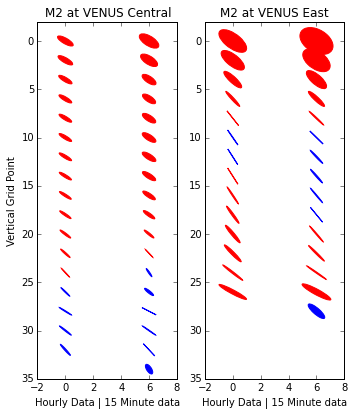

In [73]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for i in [0,2]:
    for dep in np.arange(0,40,interval):
        if ap[dep,i] > am[dep,i]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(i*3,dep), width=scale*major[dep,i], 
                            height=scale*minor[dep,i], angle=-theta[dep,i],
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)
ax.set_ylim(-2,35)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('M2 at VENUS Central')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('Hourly Data | 15 Minute data')
    
ax1 = fig.add_subplot(122)
for i in [1,3]:
    for dep in np.arange(0,40,interval):
        if ap[dep,i] > am[dep, i]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=((i-1)*3,dep), width=scale*major[dep,i], 
                            height=scale*minor[dep,i], angle=-theta[dep,i],
                            color=thec)
        ax1.add_artist(ells)
        ells.set_facecolor(thec)
ax1.set_ylim(-2,35)
ax1.invert_yaxis()
ax1.set_xlim(-2,8)
ax1.set_title('M2 at VENUS East')
ax1.set_xlabel('Hourly Data | 15 Minute data')

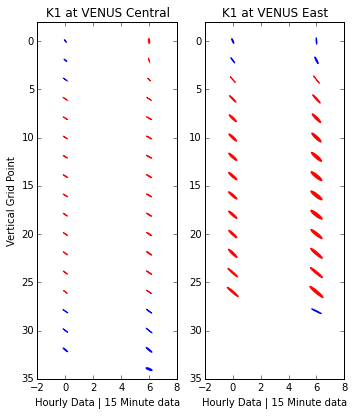

In [74]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for i in [0, 2]:
    for dep in np.arange(0,40,interval):
        if ap_k[dep,i] > am_k[dep,i]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(i*3,dep), width=scale*major_k[dep,i], 
                            height=scale*minor_k[dep,i], angle=-theta_k[dep,i],
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)
ax.set_ylim(-2,35)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('K1 at VENUS Central')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('Hourly Data | 15 Minute data')
    
ax1 = fig.add_subplot(122)
for i in [1, 3]:
    for dep in np.arange(0,40,interval):
        if ap_k[dep,i] > am_k[dep, i]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=((i-1)*3,dep), width=scale*major_k[dep,i], 
                            height=scale*minor_k[dep,i], angle=-theta_k[dep,i],
                            color=thec)
        ax1.add_artist(ells)
        ells.set_facecolor(thec)
ax1.set_ylim(-2,35)
ax1.invert_yaxis()
ax1.set_xlim(-2,8)
ax1.set_title('K1 at VENUS East')
ax1.set_xlabel('Hourly Data | 15 Minute data')

#Compare with a table

For M2 constituent at the Central Node

In [75]:
print "                 Central(15 Min)                 Central (Hourly)"
print "Depth    Major-Axis  Minor-Axis  Angle |  Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    if major[i,0] > 0 :  
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
            major[i,2], minor[i,2], theta[i,2], major[i,0], minor[i,0],  theta[i,0])
    elif major[i,2] > 0 :
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}'.format(dep_t_c[i], 
               major[i,2], minor[i,2], theta[i,2])

                 Central(15 Min)                 Central (Hourly)
Depth    Major-Axis  Minor-Axis  Angle |  Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.26        -0.12       132      0.21       -0.07       138
  2.5      0.23        -0.11       132      0.19       -0.07       138
  4.5      0.19        -0.08       131      0.18       -0.05       137
  6.5      0.18        -0.08       132      0.17       -0.05       138
  8.5      0.18        -0.07       133      0.17       -0.05       138
 10.5      0.19        -0.07       134      0.17       -0.04       138
 12.5      0.19        -0.07       135      0.17       -0.04       138
 14.6      0.18        -0.06       135      0.17       -0.03       137
 16.8      0.18        -0.05       135      0.16       -0.03       137
 19.5      0.17        -0.04       133      0.16       -0.03       135
 24.1   

For the M2 constituents at the East Node

In [76]:
print "                 Central(15 Min)                 Central (Hourly)"
print "Depth    Major-Axis  Minor-Axis  Angle |  Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    if major[i,1] > 0 :  
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
            major[i,3], minor[i,3], theta[i,3], major[i,1], minor[i,1],  theta[i,1])
    elif major[i,3] > 0 :
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}'.format(dep_t_c[i], 
               major[i,3], minor[i,3], theta[i,3])

                 Central(15 Min)                 Central (Hourly)
Depth    Major-Axis  Minor-Axis  Angle |  Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.44        -0.28       124      0.40       -0.18       128
  2.5      0.38        -0.22       125      0.35       -0.14       127
  4.5      0.32        -0.12       125      0.30       -0.08       125
  6.5      0.27        -0.05       126      0.26       -0.03       122
  8.5      0.25        -0.01       126      0.25       -0.00       119
 10.5      0.23        0.01       125      0.25       0.01       115
 12.5      0.23        0.02       123      0.25       0.00       114
 14.6      0.23        0.02       121      0.26       -0.00       114
 16.8      0.24        0.01       120      0.27       -0.01       115
 19.5      0.25        0.00       120      0.28       -0.02       116
 24.1      0.27

The longer the hourly data is run for the more there is a difference between the two frequencies. This is making me belive that is may be more benifical to have a longer term of data than a higher frquency. They are quite similar when observed over the same time period